In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

df = pd.read_csv("../kaggle_dataset/marketing_campaign/marketing_worked.csv")

In [23]:
#1. 정규화
features = ['Income', 'Age', 'Total_Spent', 
            'Total_Campaigns', 'NumWebVisitsMonth', 'Mnt_Premium', 'Education_Level']
x = df[features]

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

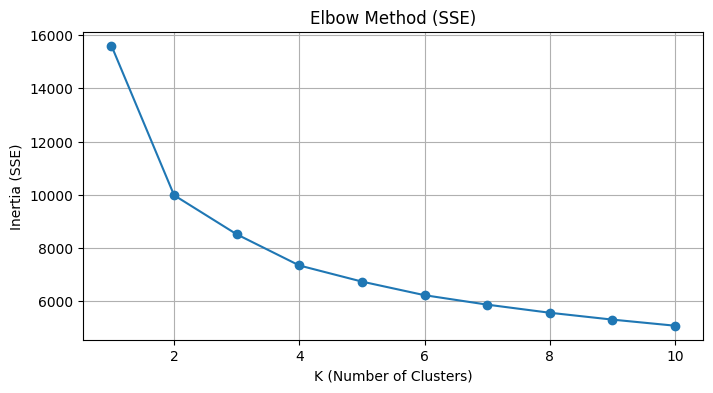

K가 1에서 2가 될 때 inertia 감소량: 5620.65
K가 2에서 3가 될 때 inertia 감소량: 1468.93
K가 3에서 4가 될 때 inertia 감소량: 1172.27
K가 4에서 5가 될 때 inertia 감소량: 606.22
K가 5에서 6가 될 때 inertia 감소량: 510.94
K가 6에서 7가 될 때 inertia 감소량: 355.24
K가 7에서 8가 될 때 inertia 감소량: 305.13
K가 8에서 9가 될 때 inertia 감소량: 257.75
K가 9에서 10가 될 때 inertia 감소량: 229.50


In [24]:
#2. Elbow : 최적의 군집(K) 찾기
inertia = []
    #inertia = 관성, SSE값이다.

for k in range(1, 11): #군집 : 1부터 10까지 확인
    #n_init : 자동으로 가장 낮은 SSE를 내는 숫자를 선택해줘서 수동X
    model = KMeans(n_clusters = k, n_init=10, random_state=42)
        #n_cluster : 군집 개수
        #n_init : 시작점 시도 횟수, 10이면 1부터 10까지 테스트
    model.fit(x_scaled)
        #fit : 학습, 최적의 중심점위치를 찾는다
            #해당 elbow method에서는 군집에 따른 SSE가 얼마인지 확인하는게 목표였음
            #-> 개별 데이터가 어느 군집인지는 상관X, fit으로 군집과 관성만 확인
        #predict : 할당, 찾아놓은 중심점을 기준으로 데이터가 어느 군집인지 번호를 매김
        #fit_predict : 중심점을 찾고 바로 군집 번호를 return
    inertia.append(model.inertia_)
        #언더바 : sklearn에서 모델을 fit(학습)한 이후에 생성된 결과물이라는 뜻

#elbow 시각화
plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method (SSE)')
plt.xlabel('K (Number of Clusters)')
plt.ylabel('Inertia (SSE)')
plt.grid(True)
plt.show()

#elbow 그래프 수치로 확인
diff = np.diff(inertia)
for i, d in enumerate(diff):
    print(f"K가 {i+1}에서 {i+2}가 될 때 inertia 감소량: {abs(d):.2f}")

k를 3이나 4로 주로 하는 이유?
#### k=2
- ex) 부자 vs 거지
    - 너무 당연한 결과, 마케팅으로 볼 게 없다
#### k=5이상
- 군집이 늘어남에 따라 SSE,관성이 급격히 떨어짐, 그래프가 겹치거나 해석하기 복잡함

감소량을 볼 때는 수치보다는 비율이 더 정확하다
elbow method에서 군집을 정했더라도 cluster scatter 분석결과
비지니스적으로 맞지 않다면 군집을 줄일 수도 있다

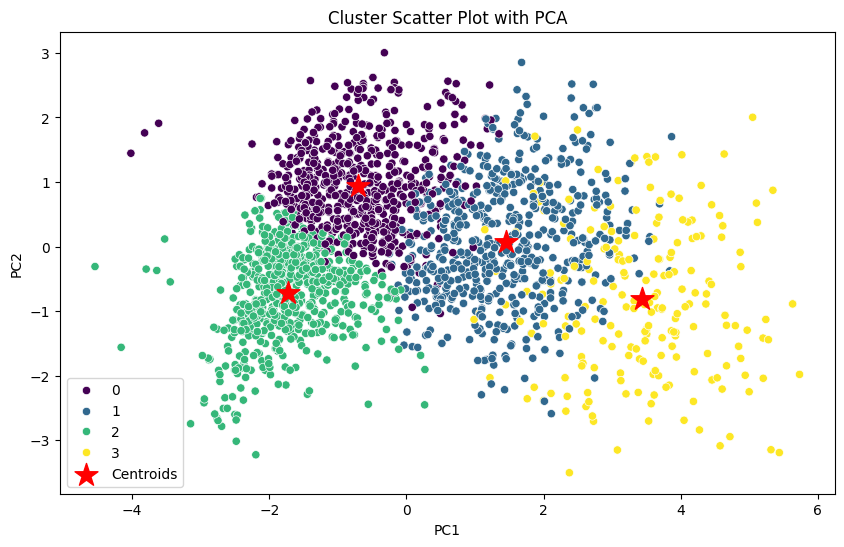

In [ ]:
#3. 차원축소(PCA) 및 산점도 확인
    #간단히 진행, 이론 및 심화는 12장에서

pca = PCA(n_components=2)
    #데이터가 가장 널리 퍼져있는 방향(= 분산)을 기준으로 변수를 섞는다
        #PCA는 각 변수들의 특징을 최소로 잃는 방법으로 축소한다 
        #모델은 비지니스나 다른 요인은 모른채 분산만을 기준으로 정한다
        #PCA의 가중치를 직접 설정할 순 없다, 다만 스케일링에서 가중을 원하는 분산을 *2하는 식으로 건들 순 있다
    #섞인 변수들로 새로운 축을 n개만큼 만듦
    #PC1 : 전체 데이터의 특징을 가장 많이 대변하는 첫번째 축
    #PC2 : 두번째로 많이 대변하는 두번째 축
        #둘다 모든 변수를 사용하지만 다른 정보를 담는다
        #=> 가중치(비중)을 다르게 한다
            #ex) PC1은 Income과 Total_Spent에 비중을 크게 실는다
            #ex) PC2는 Age와 Education_Level에 비중을 크게 실는다
x_pca = pca.fit_transform(x_scaled)

kmeans = KMeans(n_clusters=4, n_init=10, random_state=42)
    #위 elbow에서 K=4이 가장 최적화된 SSE라고 밝혀짐 (완만해지는 지점)
    #해당 k에 따른 cluster scatter 확인
df['Cluster'] = kmeans.fit_predict(x_scaled)

pca_df = pd.DataFrame(x_pca, columns=['PC1', 'PC2'])
pca_df['Cluster'] = df['Cluster']

plt.figure(figsize=(10,6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis')
    #산점도만 보고는 해석이 불가능 => 표와 함께 확인
    #아래 도메인 검증에서 확인

centers = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers[:, 0], centers[:, 1], s=300, c='red', marker='*', label='Centroids')
plt.title('Cluster Scatter Plot with PCA')
plt.legend()
plt.show()

#개별 변수에 대한 이상치를 처리했음에도 scatter그래프 상에서 이상치가 보임
#=> 여러변수가 섞임에 따라 발생하는 다변량 이상치(Multivariate Outlier)
    #해결법 1. PCA 수행 전 다변량 이상치 탐지를 사용하자
        #ex) Local Outlier Factor(LOF)알고리즘, Isolation Forest알고리즘
    #해결법 2. 스케일러 변경 -> RobustScaler
        # 평균과 표준편차를 사용하는 StandardScaler
        # 중앙값과 사분위수를 사용하는 RobustScaler

In [26]:
#4. 도메인 검증
profile = df.groupby('Cluster')[features].mean()
print(profile)

               Income        Age  Total_Spent  Total_Campaigns  \
Cluster                                                          
0        45348.550810  52.041237   250.966127         0.263623   
1        69912.863854  48.628981  1033.914013         0.235669   
2        32264.598278  38.371593   109.987088         0.177905   
3        79488.235556  45.164444  1578.035556         2.440000   

         NumWebVisitsMonth  Mnt_Premium  Education_Level  
Cluster                                                   
0                 6.075110   222.282769         4.153166  
1                 3.573248   846.122611         3.396497  
2                 6.787661    81.539455         2.750359  
3                 3.511111  1373.848889         3.728889  


각 군집마다 변수들의 평균을 알 수 있다

ex)
Cluster 3 : 수입이 높고 총 지출이 높은 VIP 집단이다. 해당 집단은 캠페인 반응도가 높고 프리미엄 상품을 선호한다